# Decision Trees

Дибель Софья Васильевна, НПМбд-01-19а

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

make_circles: Make a large circle containing a smaller circle in 2d. \
make_moons: Make two interleaving half circles. \
make_classification: Generate a random n-class classification problem.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0., )
]

In [3]:
datasets_names = ['make_circles', 'make_moons', 'make_classification']

In [4]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

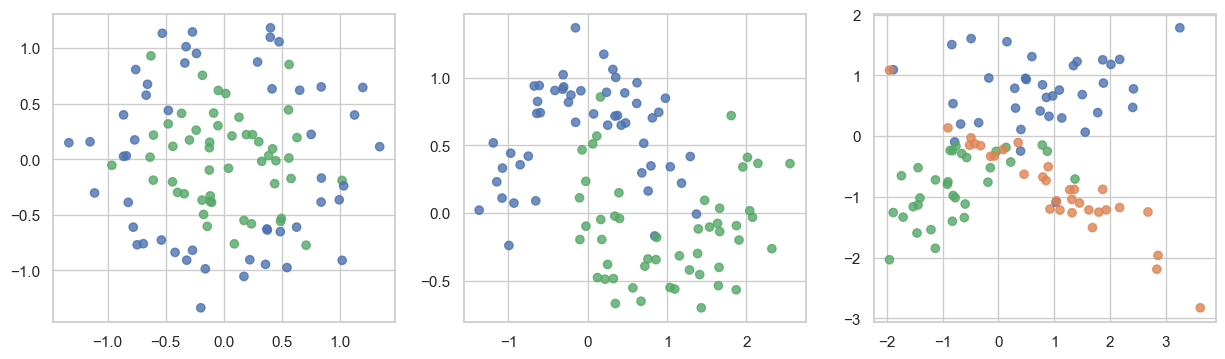

In [5]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [6]:
def plot_surface(ax, clf, X, y, accuracy=False):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    if ax == plt:
        ax.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)
    if accuracy is True:
        return clf.score(X, y)

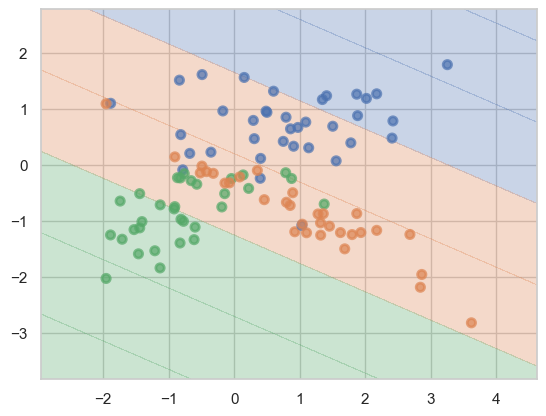

In [7]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(plt, lr, X, y)


make_circles:
train accuracy = 1.0
test accuracy = 0.7878787878787878

make_moons:
train accuracy = 1.0
test accuracy = 0.8787878787878788

make_classification:
train accuracy = 1.0
test accuracy = 0.8181818181818182


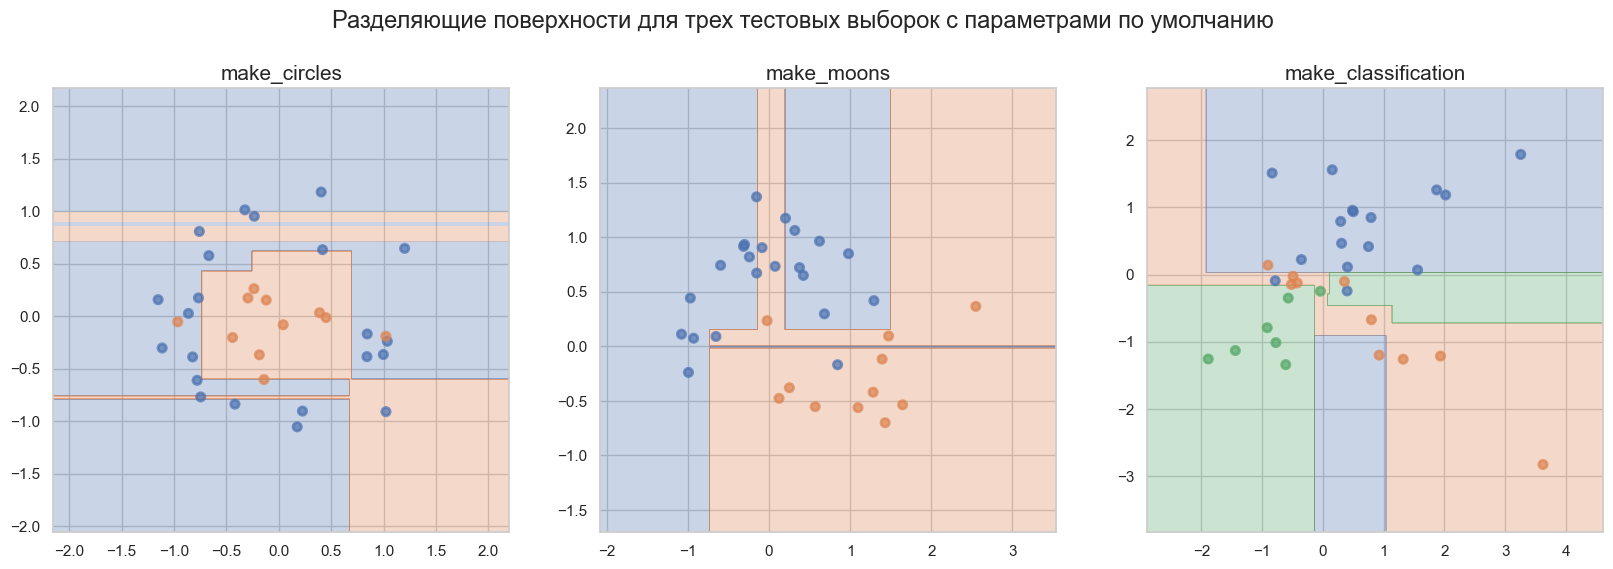

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Разделяющие поверхности для трех тестовых выборок с параметрами по умолчанию', fontsize=17)
plt.subplots_adjust(top=0.85)

for i, (x, y) in enumerate(datasets):
    print('\n' + datasets_names[i] + ':')
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    dt  = DecisionTreeClassifier().fit(X_train, y_train)
    print('train accuracy =', dt.score(X_train, y_train))
    test_accuracy = plot_surface(ax[i], dt, X_test, y_test, accuracy=True)
    print('test accuracy =', test_accuracy)
    ax[i].set_title(datasets_names[i], fontsize=15)

Вывод: построенная модель хорошо объясняет примеры из обучающей выборки (точность = 1), но относительно плохо работает на примерах, не участвовавших в обучении (на примерах из тестовой выборки) (точность = 0.75, 0.81, 0.87). В некоторых местах она строит разделяющую плоскость совсем невпопад.

__2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

Варьируем параметр max_depth:

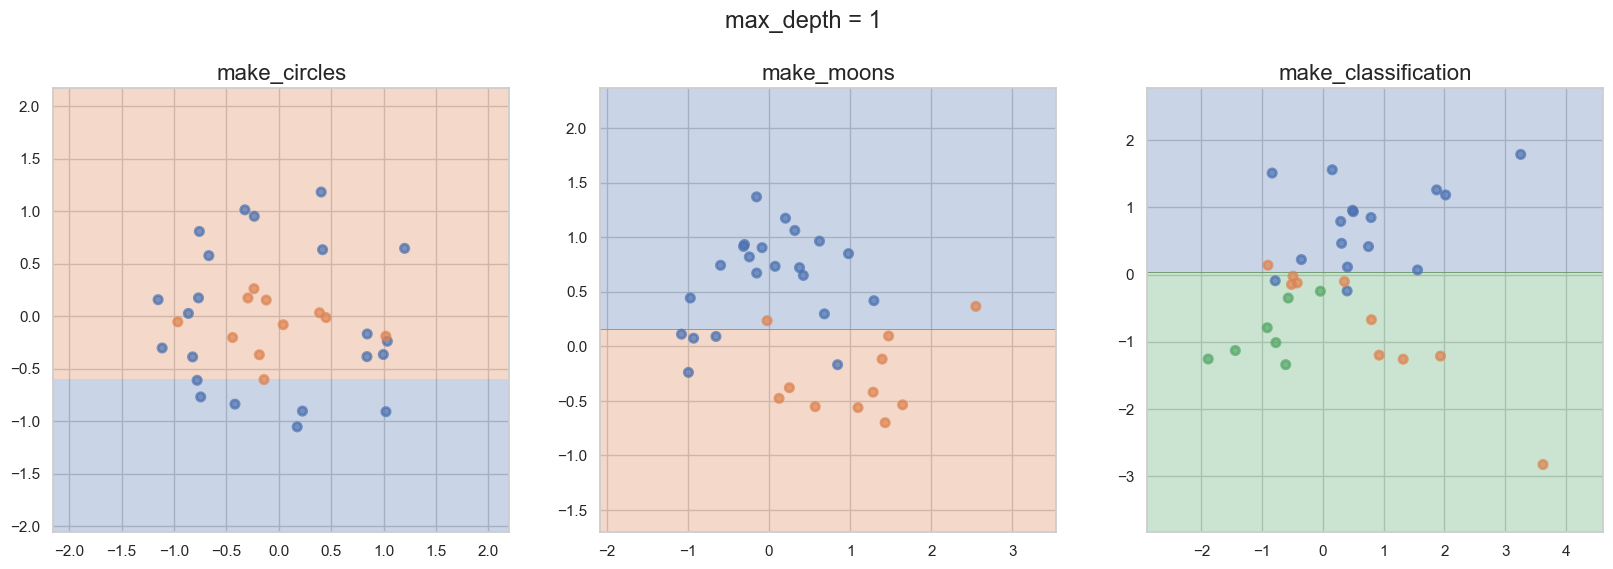

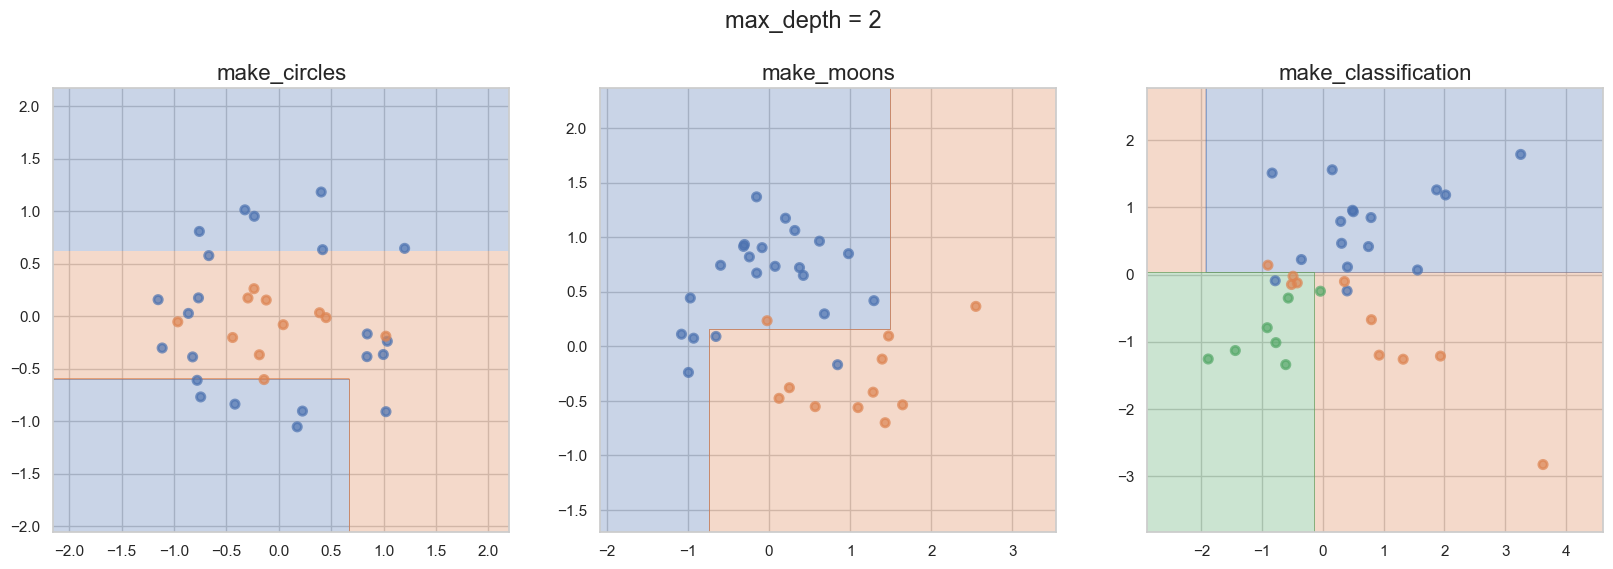

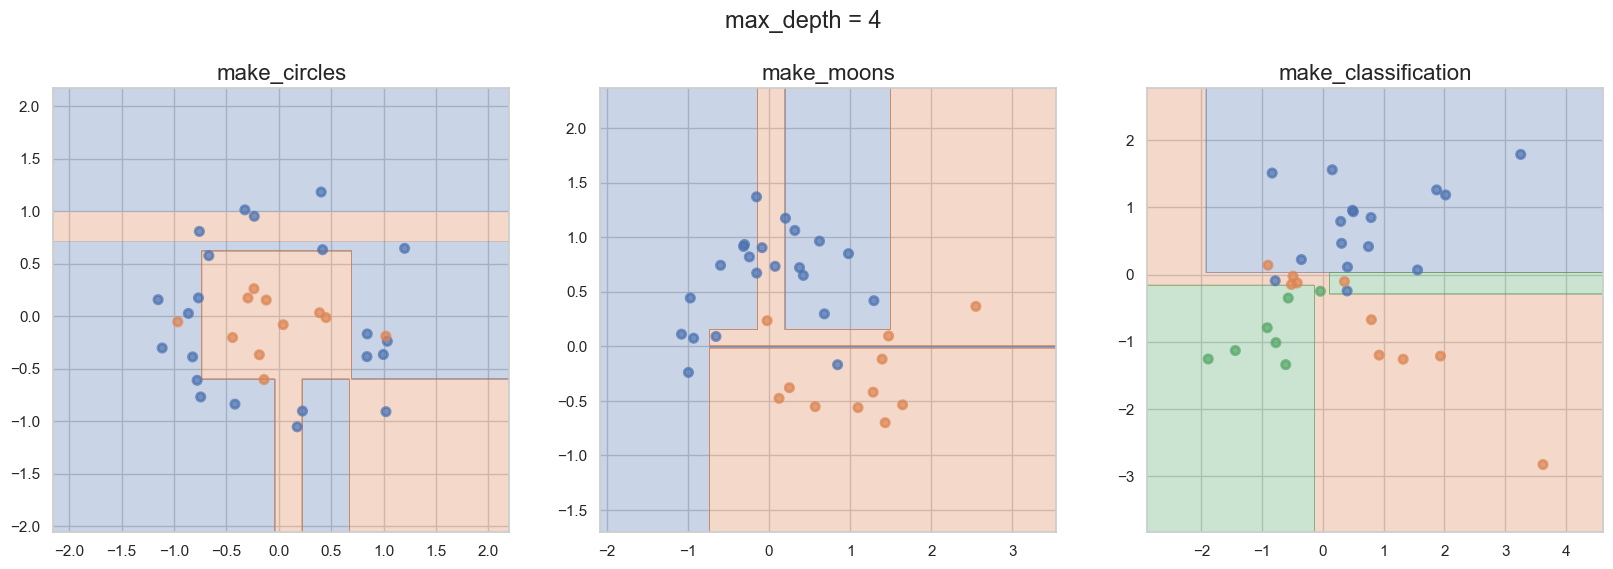

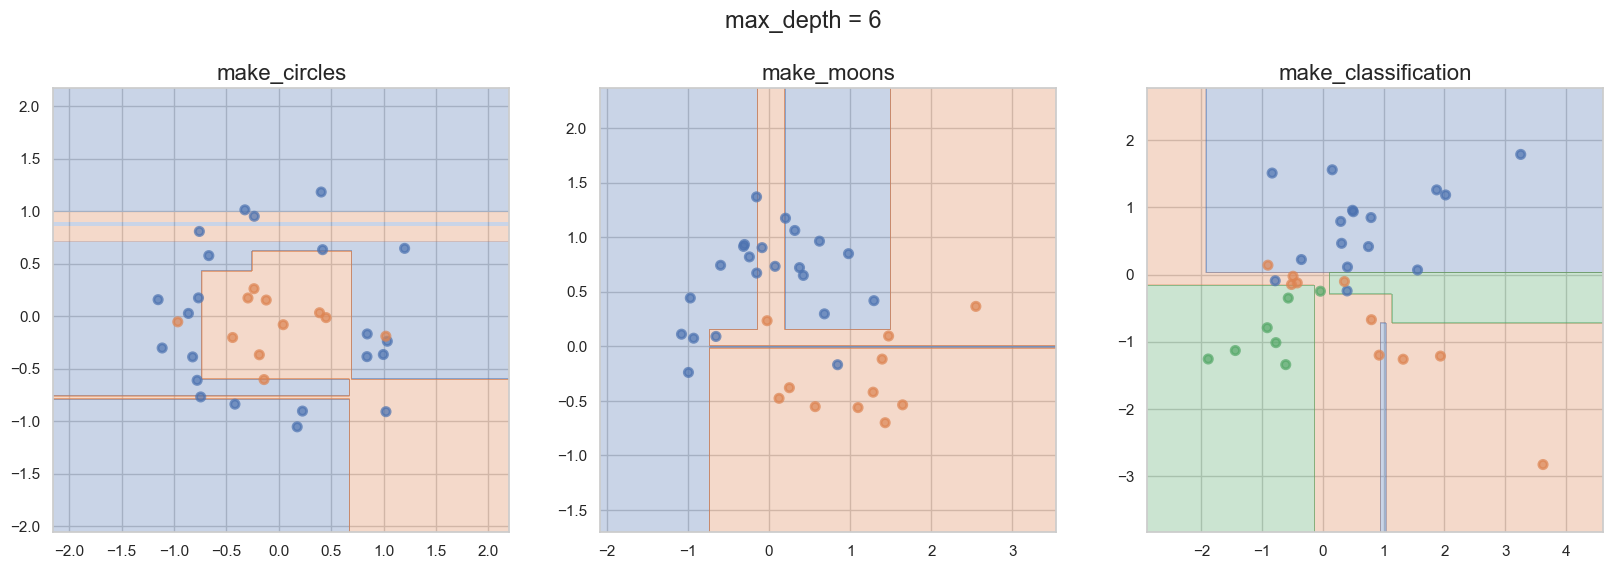

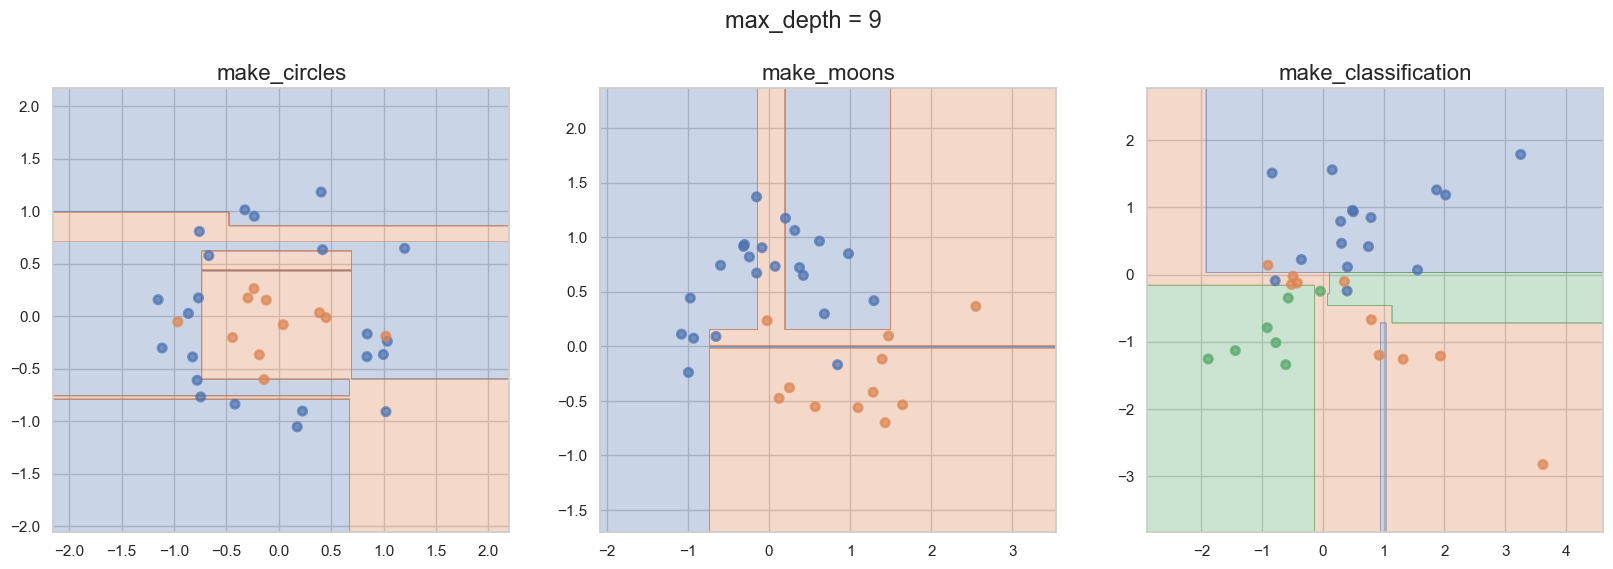

In [9]:
depths = [1, 2, 4, 6, 9]
train_accuracy = np.empty((len(depths), len(datasets)))
test_accuracy = np.empty((len(depths), len(datasets)))

for j in range(len(depths)):
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('max_depth = ' + str(depths[j]), fontsize=17)
    plt.subplots_adjust(top=0.85)
    for i, (x, y) in enumerate(datasets):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        dt  = DecisionTreeClassifier(max_depth=depths[j]).fit(X_train, y_train)
        train_accuracy[j, i] = dt.score(X_train, y_train)
        test_accur = plot_surface(ax[i], dt, X_test, y_test, accuracy=True)
        test_accuracy[j, i] = test_accur
        ax[i].set_title(datasets_names[i], fontsize=16)

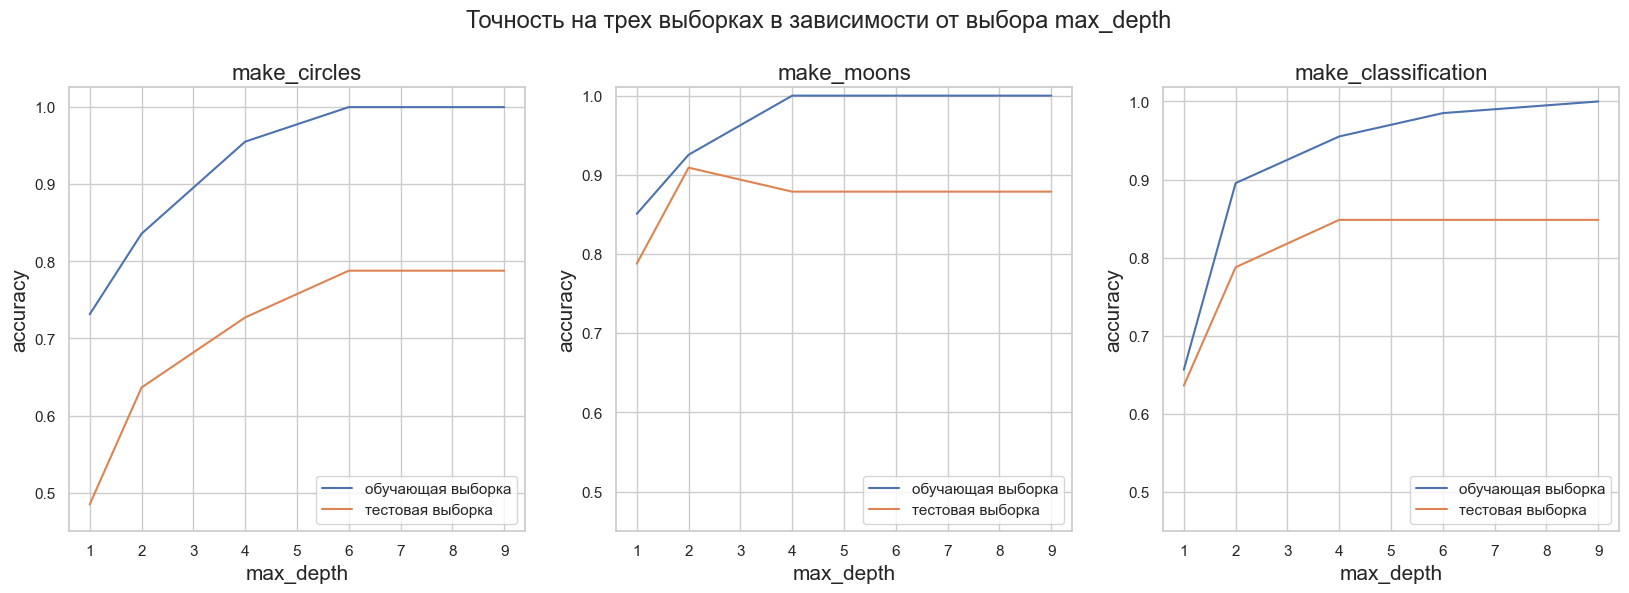

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Точность на трех выборках в зависимости от выбора max_depth', fontsize=17)
plt.subplots_adjust(top=0.85)
for j in range(len(datasets)):
    ax[j].plot(depths, train_accuracy[:, j], label='обучающая выборка')
    ax[j].plot(depths, test_accuracy[:, j], label='тестовая выборка')
    ax[j].set_ylim(0.45)
    ax[j].set_xlabel('max_depth', fontsize=15)
    ax[j].set_ylabel('accuracy', fontsize=15)
    ax[j].set_title(datasets_names[j], fontsize=16)
    ax[j].legend(loc='lower right')

Варьируем параметр min_samples_leaf:

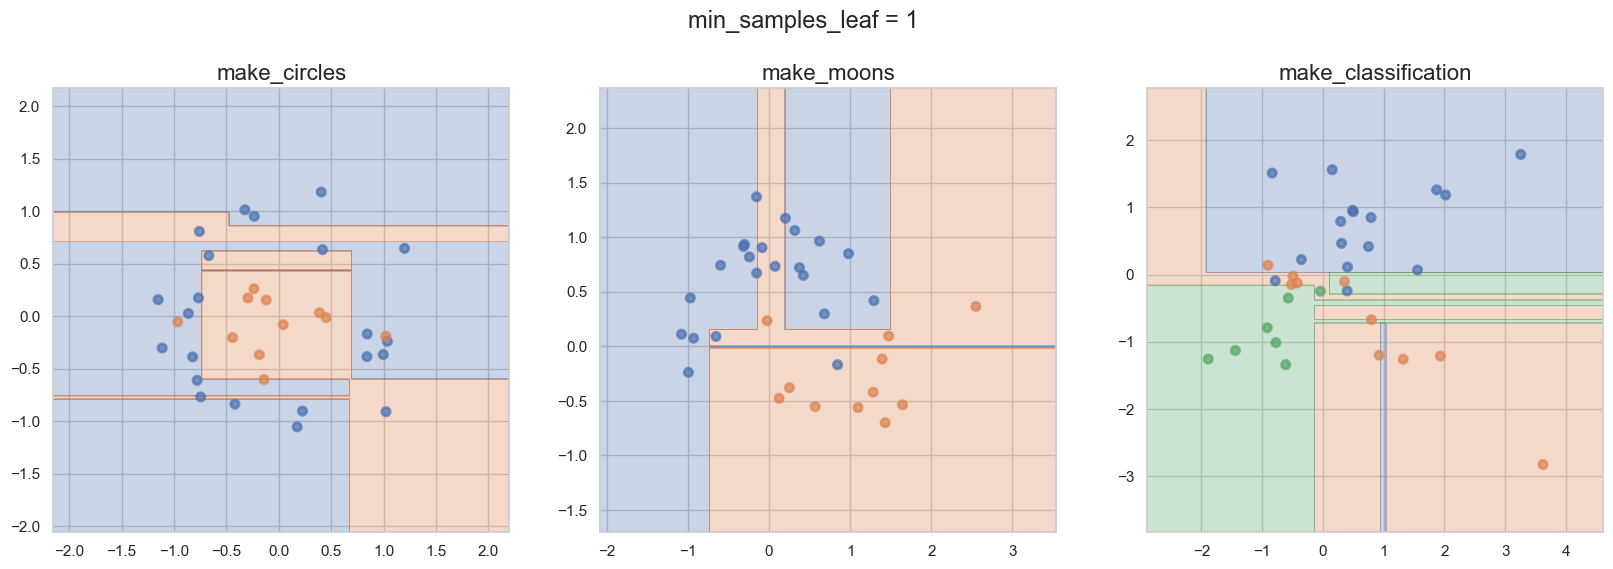

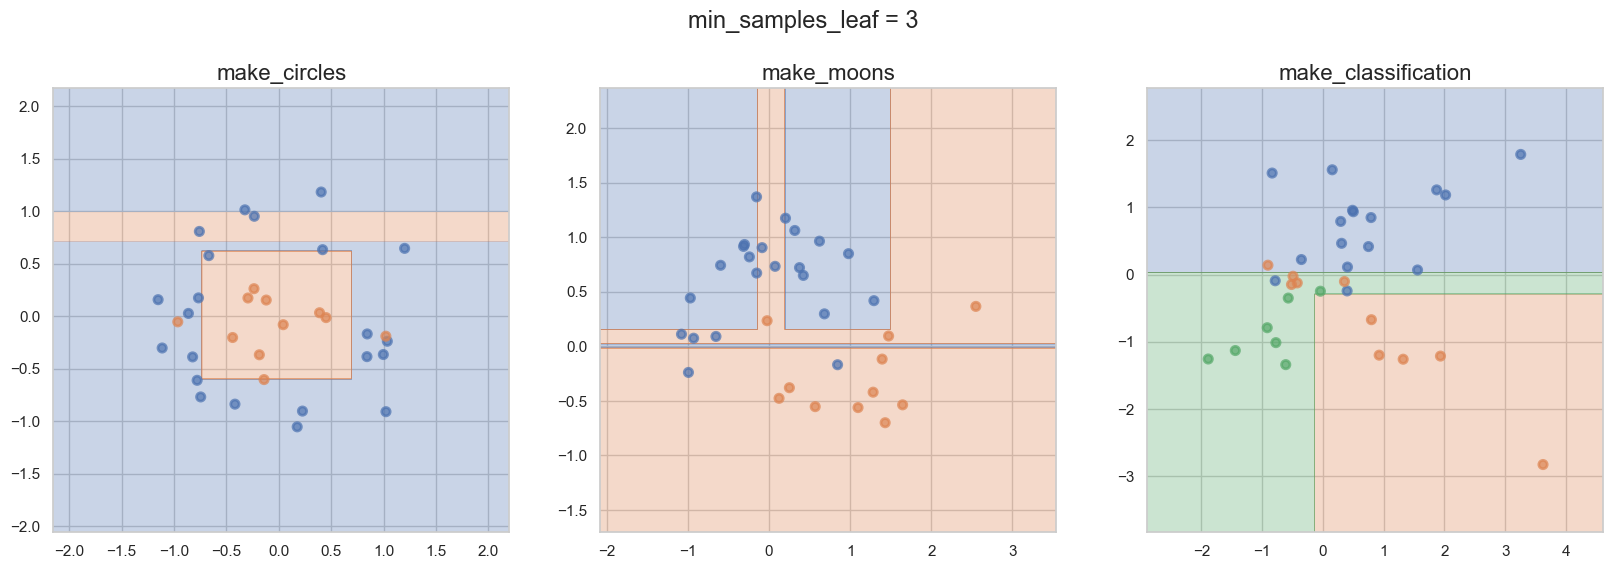

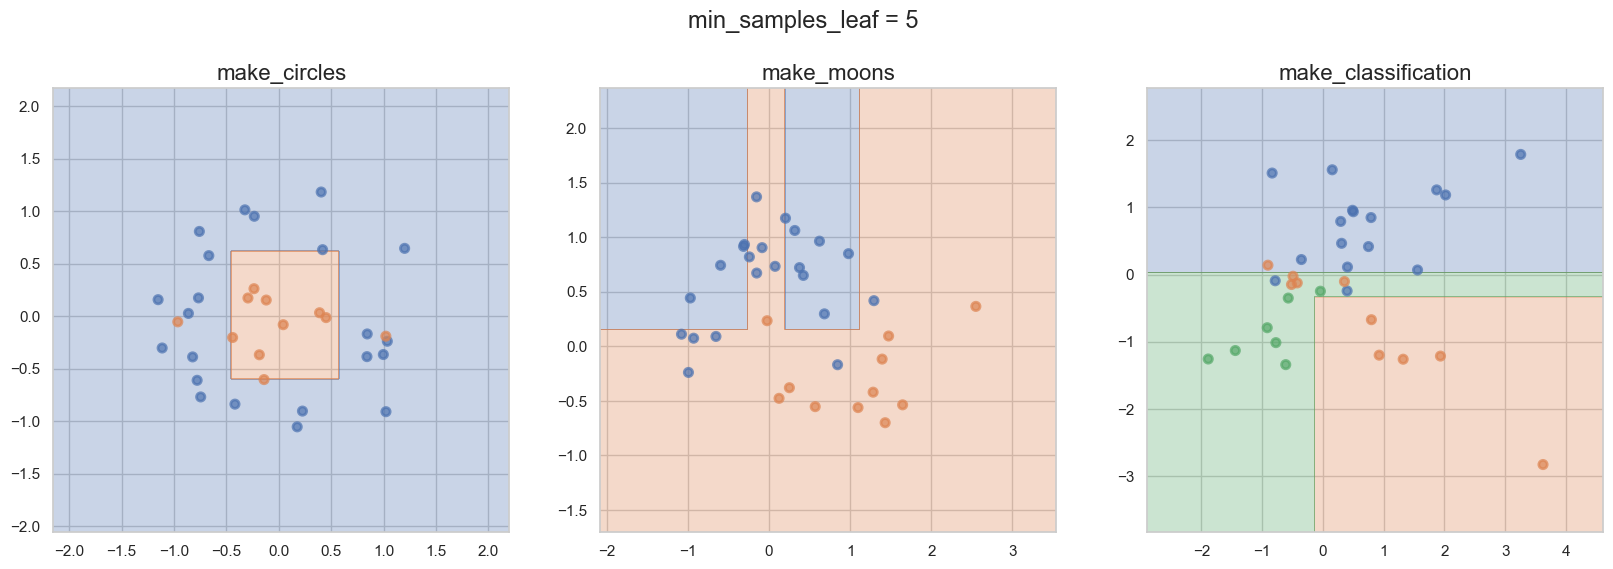

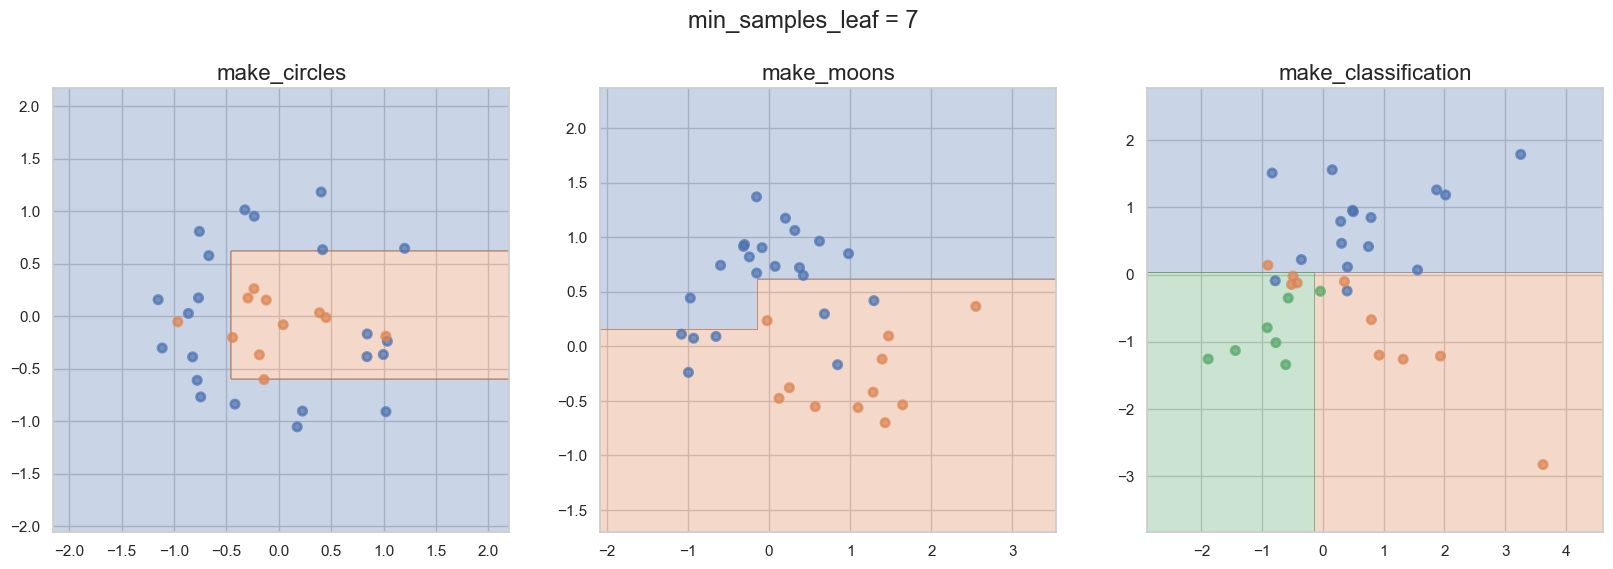

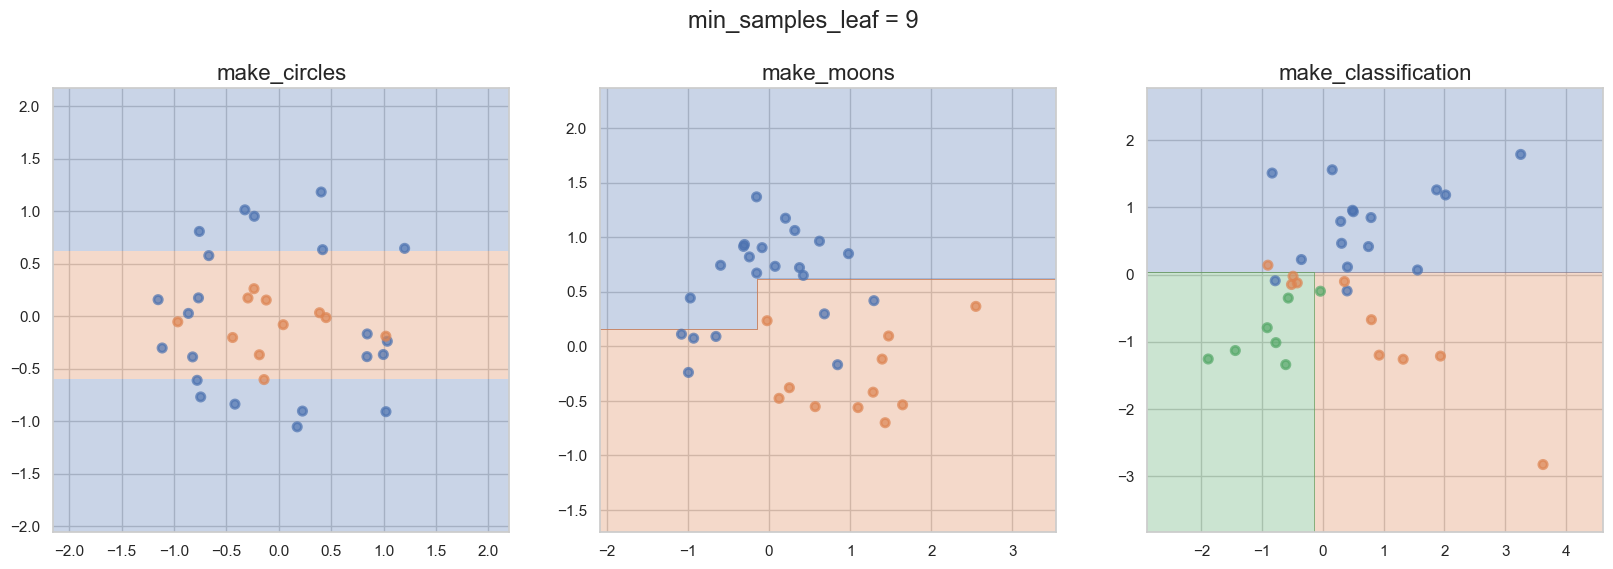

In [11]:
min_samp_leaf = [1, 3, 5, 7, 9]
train_accuracy = np.empty((len(min_samp_leaf), len(datasets)))
test_accuracy = np.empty((len(min_samp_leaf), len(datasets)))

for j in range(len(min_samp_leaf)):
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('min_samples_leaf = ' + str(min_samp_leaf[j]), fontsize=17)
    plt.subplots_adjust(top=0.85)
    for i, (x, y) in enumerate(datasets):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        dt = DecisionTreeClassifier(min_samples_leaf=min_samp_leaf[j]).fit(X_train, y_train)
        train_accuracy[j, i] = dt.score(X_train, y_train)
        test_accur = plot_surface(ax[i], dt, X_test, y_test, accuracy=True)
        test_accuracy[j, i] = test_accur
        ax[i].set_title(datasets_names[i], fontsize=16)

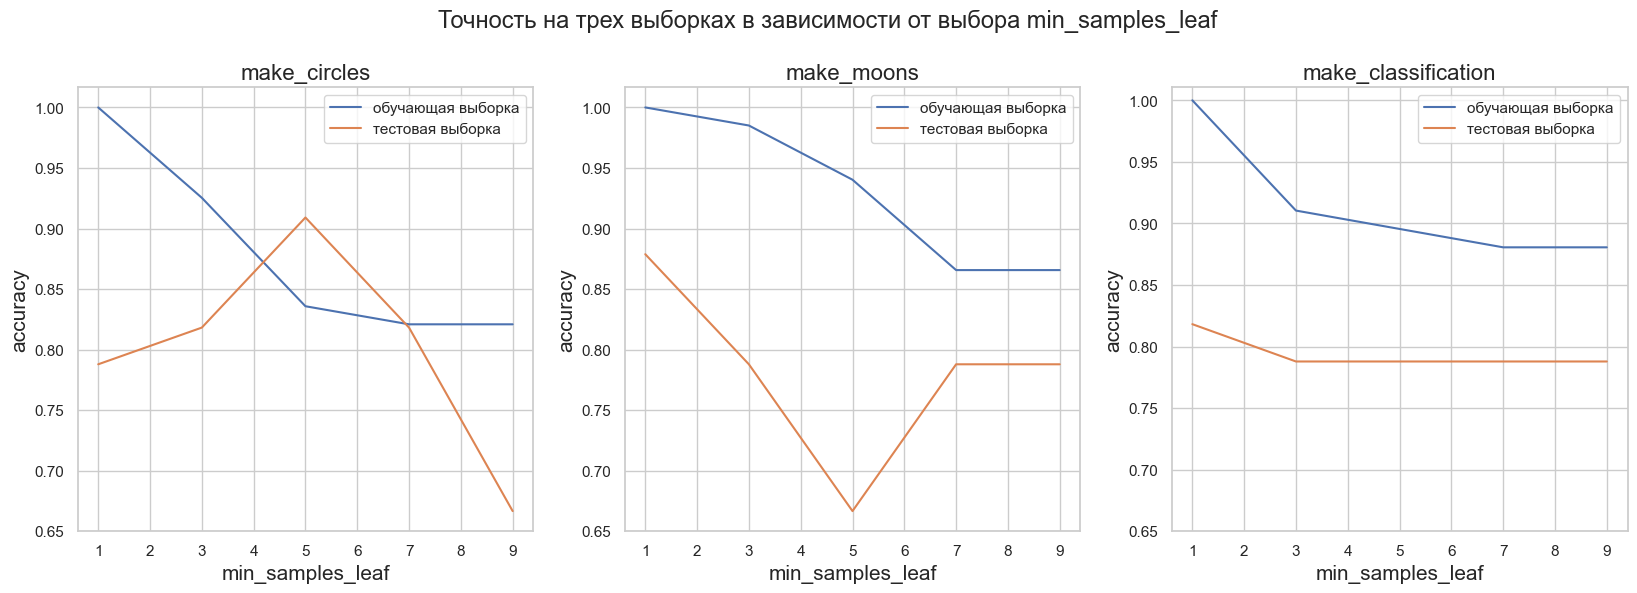

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Точность на трех выборках в зависимости от выбора min_samples_leaf', fontsize=17)
plt.subplots_adjust(top=0.85)
for j in range(len(datasets)):
    ax[j].plot(min_samp_leaf, train_accuracy[:, j], label='обучающая выборка')
    ax[j].plot(min_samp_leaf, test_accuracy[:, j], label='тестовая выборка')
    ax[j].set_ylim(0.65)
    ax[j].set_xlabel('min_samples_leaf', fontsize=15)
    ax[j].set_ylabel('accuracy', fontsize=15)
    ax[j].set_title(datasets_names[j], fontsize=16)
    ax[j].legend(loc='upper right')

Вывод: 

При увеличении max_depth и уменьшении min_samples_leaf разделяющая поверхность более сложная, обобщающая способность выше. \
При уменьшении max_depth и увеличении min_samples_leaf разделяющая поверхность более простая, обобщаяющая способность ниже.

Для справки:\
**max_depth:** The maximum depth of the tree.\
**min_samples_leaf:** The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = H(R) -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$
    $R$ — множество объектов, \
    $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево, \
    $H(R) = 1-p_1^2-p_0^2$, \
    $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

In [13]:
def find_best_split(feature_vector, target_vector):
    """
    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    
    def Hr(y):
        if len(y) == 0:
            return 0

        p0 = len(y[y == 0]) / len(y)
        p1 = 1 - p0

        return 1 - p1 ** 2 - p0 ** 2
    
    sorted_ind = np.argsort(feature_vector)
    R = feature_vector[sorted_ind]
    y = target_vector[sorted_ind]
    
    thresholds = (R[1:] + R[:-1]) / 2
    ginis = np.array([])
    gini_best = None
    threshold_best = None
        
    for t in thresholds:   
        R_l = R[R < t]
        R_r = R[R >= t]
        
        y_l = y[R < t]
        y_r = y[R >= t]
        
        H_R = Hr(y)
        H_Rl = Hr(y_l)
        H_Rr = Hr(y_r)
        
        Q = H_R - len(R_l) / len(R) * H_Rl - len(R_r) / len(R) * H_Rr

        if gini_best is None or Q > gini_best:
            gini_best = Q
            threshold_best = t
            
        ginis = np.append(ginis, Q)
        
    return thresholds, ginis, threshold_best, gini_best

__4. (0.5 балла)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [14]:
students_train = pd.read_excel('/Users/sofia.dibel/Пакеты/Autumn/homework-7/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls', sheet_name='Training_Data')
students_train.drop(['Unnamed: 6', 'Unnamed: 7', 'Attribute Information:'], axis=1, inplace=True)

students_train.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,very_low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low


In [15]:
print(students_train['UNS'].unique())

['very_low' 'High' 'Low' 'Middle']


In [16]:
students_train.loc[(students_train['UNS'] == 'very_low'), 'UNS'] = 'Low'
students_train.loc[(students_train['UNS'] == 'Middle'), 'UNS'] = 'High'

le = LabelEncoder()
for col_name in students_train.columns:
    students_train.loc[:, col_name] = le.fit_transform(students_train.loc[:, col_name])

target_students_train = np.array(students_train['UNS'])
features_students_train = np.array(students_train.drop('UNS', axis=1))

Лучший порог= 31.5


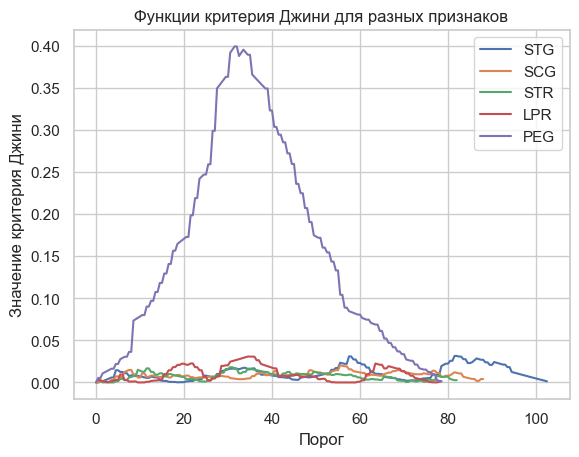

In [17]:
for i in range(features_students_train.shape[1]):
    thresholds, ginis, threshold_best, gini_best = find_best_split(features_students_train[:, i], target_students_train)
    plt.plot(thresholds, ginis)
plt.xlabel('Порог')
plt.ylabel('Значение критерия Джини')
plt.title('Функции критерия Джини для разных признаков')
plt.legend(students_train.columns)
print('Лучший порог=', threshold_best)

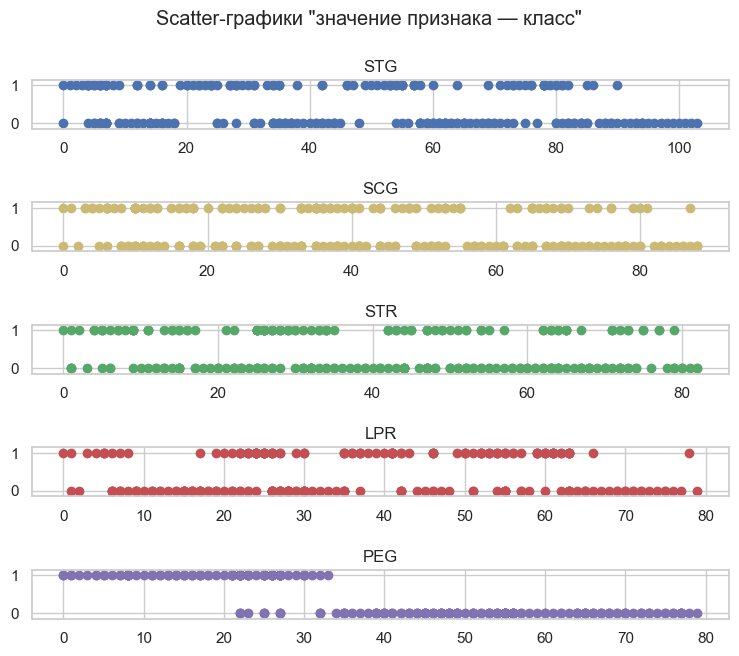

In [18]:
fig, ax = plt.subplots(5, 1, figsize=(9, 7))
fig.suptitle('Scatter-графики "значение признака — класс"')
plt.subplots_adjust(hspace=1.5)
colors = ['b', 'y', 'g', 'r', 'm']
for i in range(5):
    ax[i].scatter(features_students_train[:, i], target_students_train, c=colors[i])
    ax[i].set_ylim(-0.15, 1.15)
    ax[i].set_title(students_train.columns[i])

__5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Вывод:** Исходя из кривых значений критерия Джини, нужно производить деление выборки на два поддерева по признаку PEG (график для этого признака имеет выраженный максимум, в то время как остальные графики колеблятся примерно на одном уровне). Этот результат согласуется с визуальной оценкой scatter-графиков (только у признака PEG выражено разделение по классам в зависимости от значения признака: фукнция find_best_split возвращает наилучший порог = 31.5, что совпадает с визуальной оценкой порога на scatter-графике).

__6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [19]:
mushrooms = pd.read_csv('agaricus-lepiota.data')
mushrooms.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [20]:
le = LabelEncoder()
for col_name in mushrooms.columns:
    mushrooms.loc[:, col_name] = le.fit_transform(mushrooms.loc[:, col_name])
mushrooms.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [21]:
target_mushrooms = np.array(mushrooms['p'])
features_mushrooms = np.array(mushrooms.drop('p', axis=1))
X_train, X_test, y_train, y_test = train_test_split(features_mushrooms, target_mushrooms, test_size=0.5, random_state=42)
dt_mushrooms = DecisionTreeClassifier().fit(X_train, y_train)
print('Точность для тестовой выборки:', dt_mushrooms.score(X_test, y_test))
print('Глубина дерева:', dt_mushrooms.get_depth())

Точность для тестовой выборки: 1.0
Глубина дерева: 7


__14. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [22]:
tic_tac_toe = pd.read_csv('tic-tac-toe.data')
tic_tac_toe.head()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,x,x,x,x,o,o,o,x,o,positive
1,x,x,x,x,o,o,o,o,x,positive
2,x,x,x,x,o,o,o,b,b,positive
3,x,x,x,x,o,o,b,o,b,positive
4,x,x,x,x,o,o,b,b,o,positive


In [23]:
le = LabelEncoder()
for col_name in tic_tac_toe.columns:
    tic_tac_toe.loc[:, col_name] = le.fit_transform(tic_tac_toe.loc[:, col_name])
tic_tac_toe.head()

,x,x.1,x.2,x.3,o,o.1,x.4,o.2,o.3,positive
0,2,2,2,2,1,1,1,2,1,1
1,2,2,2,2,1,1,1,1,2,1
2,2,2,2,2,1,1,1,0,0,1
3,2,2,2,2,1,1,0,1,0,1
4,2,2,2,2,1,1,0,0,1,1


In [24]:
target_tic_tac_toe = np.array(tic_tac_toe['positive'])
features_tic_tac_toe = np.array(tic_tac_toe.drop('positive', axis=1))
X_train, X_test, y_train, y_test = train_test_split(features_tic_tac_toe, target_tic_tac_toe, test_size=0.5, random_state=42)

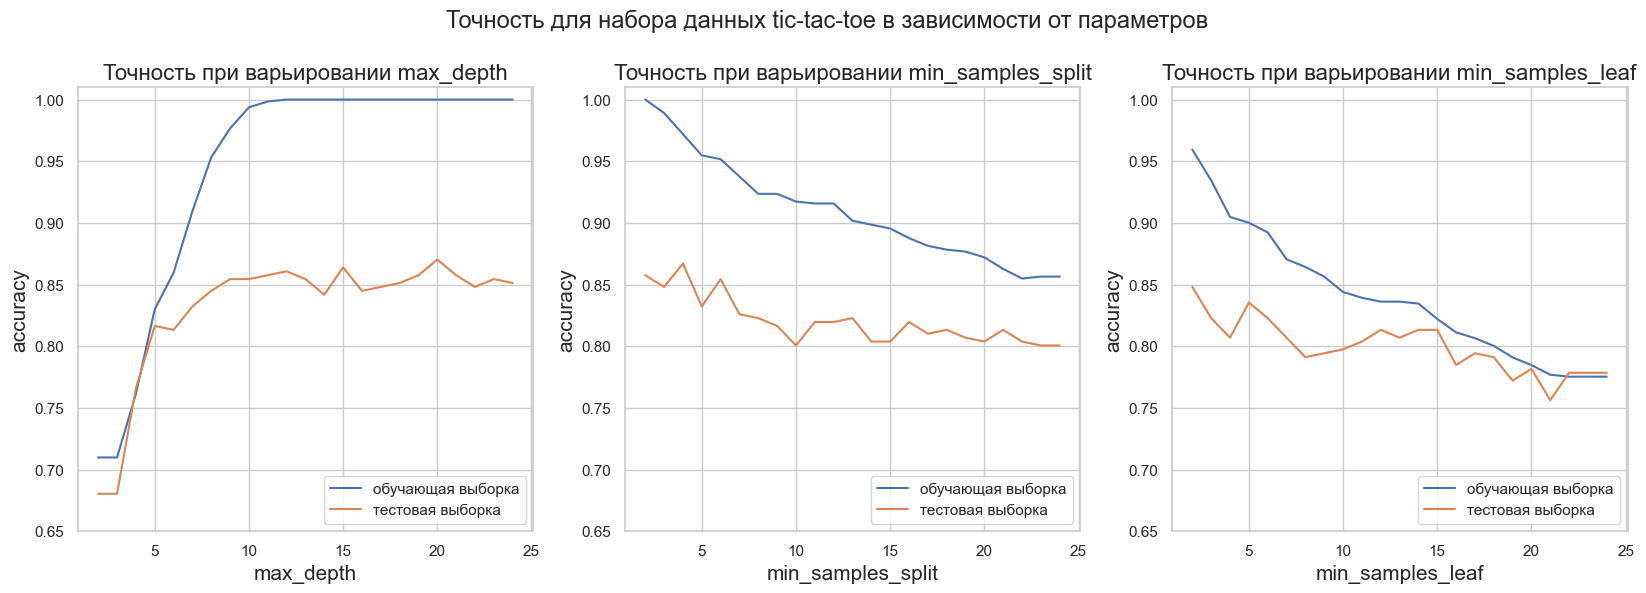

In [25]:
v = np.arange(2, 25)
param_names = ['max_depth', 'min_samples_split', 'min_samples_leaf']

train_accuracy = np.empty((len(v), len(param_names)))
test_accuracy = np.empty((len(v), len(param_names)))

for j in range(len(v)):
    for i in range(len(param_names)):
        parameter = param_names[i]
        X_train, X_test, y_train, y_test = train_test_split(features_tic_tac_toe, target_tic_tac_toe, test_size=0.33, random_state=42)
        dt_max_depth = DecisionTreeClassifier(max_depth=v[j]).fit(X_train, y_train)
        dt_min_samples_split = DecisionTreeClassifier(min_samples_split=v[j]).fit(X_train, y_train)
        dt_min_samples_leaf = DecisionTreeClassifier(min_samples_leaf=v[j]).fit(X_train, y_train)
        
        train_accuracy[j, 0] = dt_max_depth.score(X_train, y_train)
        test_accuracy[j, 0] = dt_max_depth.score(X_test, y_test)
        train_accuracy[j, 1] = dt_min_samples_split.score(X_train, y_train)
        test_accuracy[j, 1] = dt_min_samples_split.score(X_test, y_test)
        train_accuracy[j, 2] = dt_min_samples_leaf.score(X_train, y_train)
        test_accuracy[j, 2] = dt_min_samples_leaf.score(X_test, y_test)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Точность для набора данных tic-tac-toe в зависимости от параметров', fontsize=17)
plt.subplots_adjust(top=0.85)
for j in range(len(param_names)):
    ax[j].plot(v, train_accuracy[:, j], label='обучающая выборка')
    ax[j].plot(v, test_accuracy[:, j], label='тестовая выборка')
    ax[j].set_ylim(0.65, 1.01)
    ax[j].set_xlabel(param_names[j], fontsize=15)
    ax[j].set_ylabel('accuracy', fontsize=15)
    ax[j].set_title('Точность при варьировании ' + param_names[j], fontsize=16)
    ax[j].legend(loc='lower right')

Для справки:\
**max_depth:** The maximum depth of the tree.\
**min_samples_split:** The minimum number of samples required to split an internal node. \
**min_samples_leaf:** The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches.


__15. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [26]:
cars = pd.read_csv('car.data')
cars.head()

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc


In [27]:
cars.loc[(cars['unacc'] == 'unacc'), 'unacc'] = 'acc'
cars.loc[(cars['unacc'] == 'vgood'), 'unacc'] = 'good'
cars['unacc'].unique()

array(['acc', 'good'], dtype=object)

In [28]:
le = LabelEncoder()
for col_name in cars.columns:
    cars.loc[:, col_name] = le.fit_transform(cars.loc[:, col_name])
target_cars = cars['unacc']
features_cars = cars.drop('unacc', axis=1)

In [29]:
nursery = pd.read_csv('nursery.data')
nursery.head()

,usual,proper,complete,1,convenient,convenient.1,nonprob,recommended,recommend
0,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
1,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
2,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
3,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
4,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,not_recom


In [30]:
nursery.loc[(nursery['recommend'] == 'not_recom'), 'recommend'] = 'recommend'
nursery.loc[(nursery['recommend'] == 'very_recom') | (nursery['recommend'] == 'spec_prior'), 'recommend'] = 'priority'
nursery['recommend'].unique()

array(['priority', 'recommend'], dtype=object)

In [31]:
le = LabelEncoder()
for col_name in nursery.columns:
    nursery.loc[:, col_name] = le.fit_transform(nursery.loc[:, col_name])
target_nursery = nursery['recommend']
features_nursery = nursery.drop('recommend', axis=1)

In [32]:
print('Accuracy mushrooms:', cross_val_score(DecisionTreeClassifier(), features_mushrooms, target_mushrooms, cv=10, scoring=make_scorer(accuracy_score)).mean())
print('Accuracy tic_tac_toe:', cross_val_score(DecisionTreeClassifier(), features_tic_tac_toe, target_tic_tac_toe, cv=10, scoring=make_scorer(accuracy_score)).mean())
print('Accuracy cars:', cross_val_score(DecisionTreeClassifier(), features_cars, target_cars, cv=10, scoring=make_scorer(accuracy_score)).mean())
print('Accuracy nursery:', cross_val_score(DecisionTreeClassifier(), features_nursery, target_nursery, cv=10, scoring=make_scorer(accuracy_score)).mean())

Accuracy mushrooms: 0.9627233562976023
Accuracy tic_tac_toe: 0.7527192982456139
Accuracy cars: 0.9443708831832234
Accuracy nursery: 0.9998456790123458


На наборе данны nursery точность высокая, на tic_tac_toe - достаточно низкая.